Columns in the dataset: ['Id', 'Text', 'Emotions', 'Category', 'Emoticon']
Unique values in 'Emotions': ["['SMILING FACE WITH SMILING EYES , 0.644']"
 "['HEAVY BLACK HEART , 0.746', 'SPARKLES , 0.351', 'PALM TREE , 0.525', 'EAR OF RICE , 0.538', 'FOUR LEAF CLOVER , 0.285', 'HEART WITH RIBBON , 0.644']"
 "['TWO HEARTS , 0.632']" ...
 "['REVOLVING HEARTS , 0.739', 'FACE WITH TEARS OF JOY , 0.221', 'HEAR-NO-EVIL MONKEY , 0.333']"
 "['BOX DRAWINGS LIGHT QUADRUPLE DASH HORIZONTAL , -0.588', 'WHITE STAR , 0.428']"
 nan]
Unique values in mapped_category: ['positive' 'neutral' 'negative' nan]


<ipython-input-5-14b4cff8fd1d>:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('mapped_category', group_keys=False).apply(


Map:   0%|          | 0/63674 [00:00<?, ? examples/s]

Map:   0%|          | 0/13644 [00:00<?, ? examples/s]

Map:   0%|          | 0/13645 [00:00<?, ? examples/s]

Some weights of UrduBertForClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.029100,0.993745,0.489812,0.518706,0.489812,0.485733
2,0.977000,0.969922,0.507769,0.525567,0.507769,0.499974


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.029100,0.993745,0.489812,0.518706,0.489812,0.485733
2,0.977000,0.969922,0.507769,0.525567,0.507769,0.499974
3,0.924100,0.961842,0.523527,0.518092,0.523527,0.518047
4,0.852300,0.984799,0.523747,0.548108,0.523747,0.523539
5,0.775300,1.027926,0.522281,0.521829,0.522281,0.518964
6,0.690800,1.095979,0.524846,0.524153,0.524846,0.522688
7,0.628100,1.192336,0.521914,0.523955,0.521914,0.522559


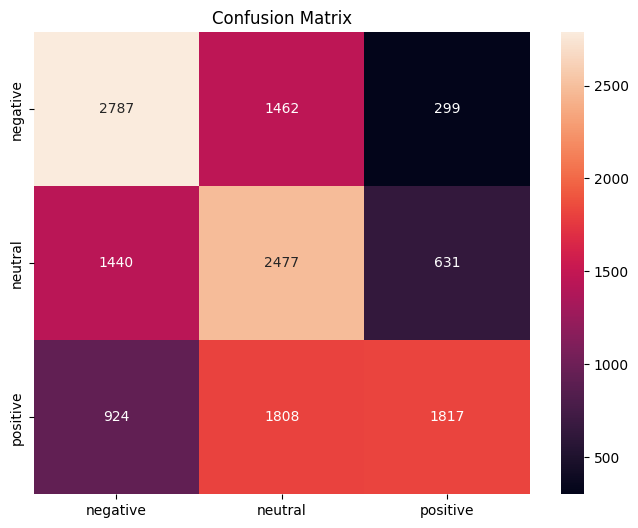

              precision    recall  f1-score   support

    negative     0.5411    0.6128    0.5747      4548
     neutral     0.4310    0.5446    0.4812      4548
    positive     0.6614    0.3994    0.4981      4549

    accuracy                         0.5189     13645
   macro avg     0.5445    0.5190    0.5180     13645
weighted avg     0.5445    0.5189    0.5180     13645


Sample Errors:
                                              clean_text  label  pred
3008          سچی بات کہی آپ نے گھر کے برتن دوتا ہوں میں      2     0
3238                                         ہمت کے ساتھ      1     0
8928                                           منو کشتتت      1     0
12537  اچھا ہے پاکستان آجائے خوب گزرے گی جب نکا وڈا چ...      2     1
2874     تے چھڈ پراں تو عامر لیاقت نال پینگاں پانیاں؟؟؟؟      2     1
Model saved to /content/drive/MyDrive/NLP_Project_Colab/Sentiment Analysis Model


In [5]:
# Disable wandb and setup environment
import os
os.environ["WANDB_DISABLED"] = "true"
'''
# Install required packages
!pip install tensorflow==2.15.0 tensorflow-addons==0.23.0 keras==2.15.0
!pip install transformers datasets scikit-learn urduhack openpyxl tensorflow-addons emoji requests

# Download urduhack resources
import urduhack
urduhack.download()

# Import libraries
import re
import unicodedata
import numpy as np
import pandas as pd
import torch
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, KFold
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    BertPreTrainedModel,
    BertModel
)
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
'''
# Configuration
MODEL_NAME = "bert-base-multilingual-uncased"  # Fallback model; update if a specialized Urdu model is available.
DATA_PATH = "https://docs.google.com/spreadsheets/d/1rSRN-wX03-44DLYo3VvZ85qH4W0DS4Mb/export?format=xlsx"
OUTPUT_DIR = "/content/drive/MyDrive/NLP_Project_Colab/Sentiment Analysis Model"
MAX_LENGTH = 256  # Increased for better context

# Enhanced text preprocessing with emoji handling
def clean_text(text):
    text = str(text)
    # Preserve Urdu punctuation and symbols (including ؟،۔ and !)
    text = re.sub(r'[^\u0600-\u06FF\s؟۔،!]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return urduhack.normalize(text)

# Improved label mapping with fixed thresholds
def map_emotion(emotion_str):
    if pd.isna(emotion_str):
        return np.nan
    numbers = re.findall(r'-?\d+\.?\d*', emotion_str)
    if not numbers:
        return np.nan
    scores = [float(n) for n in numbers]
    avg_score = np.mean(scores)
    if avg_score > 0.25:
        return "positive"
    elif avg_score < -0.25:
        return "negative"
    else:
        return "neutral"

# Custom model architecture with dropout
class UrduBertForClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(config.hidden_size, 3)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 3), labels.view(-1))
        return (loss, logits) if loss is not None else logits

# Data loading and preparation
def load_and_prepare_data():
    # Read the Excel file using openpyxl engine
    xls = pd.ExcelFile(DATA_PATH, engine='openpyxl')
    df = pd.concat([pd.read_excel(xls, sheet_name=0), pd.read_excel(xls, sheet_name=1)])
    print("Columns in the dataset:", df.columns.tolist())
    print("Unique values in 'Emotions':", df['Emotions'].unique())
    df['clean_text'] = df['Text'].apply(clean_text)
    df['mapped_category'] = df['Emotions'].apply(map_emotion)
    print("Unique values in mapped_category:", df['mapped_category'].unique())
    df = df[df['mapped_category'].notna()]
    # Dynamic class balancing using minimum count
    class_counts = df['mapped_category'].value_counts()
    target_size = int(class_counts.min())
    df_balanced = df.groupby('mapped_category', group_keys=False).apply(
        lambda x: x.sample(target_size, random_state=42)
    )
    df_balanced = df_balanced.reset_index(drop=True)
    return df_balanced

# Dataset preparation with proper stratification
def prepare_datasets(df):
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['label'] = df['mapped_category'].map(label_map)
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
    return DatasetDict({
        'train': Dataset.from_pandas(train_df[['clean_text', 'label']]),
        'validation': Dataset.from_pandas(val_df[['clean_text', 'label']]),
        'test': Dataset.from_pandas(test_df[['clean_text', 'label']])
    })

# Tokenization of dataset using the model's tokenizer
def tokenize_dataset(dataset):
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    def tokenize_fn(examples):
        return tokenizer(
            examples['clean_text'],
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH
        )
    return dataset.map(tokenize_fn, batched=True)

# Define compute_metrics function for Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# Custom trainer with class weights
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        if isinstance(outputs, tuple):
            logits = outputs[1]
        else:
            logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, 3), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Main workflow
if __name__ == "__main__":
    # Prepare data
    df = load_and_prepare_data()
    dataset = prepare_datasets(df)

    # Calculate class weights
    classes = df['mapped_category'].map({'negative': 0, 'neutral': 1, 'positive': 2})
    class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)

    # Tokenization
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenized_dataset = tokenize_dataset(dataset)
    tokenized_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    # Model initialization using custom model architecture
    model = UrduBertForClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
        label2id={'negative': 0, 'neutral': 1, 'positive': 2}
    )

    # Training setup with hyperparameter tuning
    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.01,
        warmup_ratio=0.1,
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        fp16=True,
        report_to=None
    )

    trainer = WeightedTrainer(
        class_weights=class_weights,
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['validation'],
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Training
    trainer.train()

    # Evaluation
    test_results = trainer.predict(tokenized_dataset['test'])
    y_pred = np.argmax(test_results.predictions, axis=1)
    y_true = test_results.label_ids

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title('Confusion Matrix')
    plt.show()

    # Detailed Report
    print(classification_report(y_true, y_pred,
                                target_names=['negative', 'neutral', 'positive'],
                                digits=4))

    # Error Analysis
    test_df = tokenized_dataset['test'].to_pandas()
    test_df['pred'] = y_pred
    errors = test_df[test_df['label'] != test_df['pred']]
    print("\nSample Errors:")
    print(errors.sample(5)[['clean_text', 'label', 'pred']])

    # Save model and tokenizer
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    print(f"Model saved to {OUTPUT_DIR}")
